In [1]:
import torch
print(torch.cuda.is_available())

True


In [1]:
from datasets import load_dataset

dataset = load_dataset("DataPreprocessing/dataset")
dataset

/home/abdo/anaconda3/envs/donutocr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = dataset["train"][0]
sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=624x1000>,
 'ground_truth': '{"gt_parse": {"text_sequence": "Rumsey Street\\n2 Rumsey\\nStreet, Sheung Wan, HK\\nEX 41\\t28/10/21 19:34\\nReceipt 014865\\nShort-term parking\\nOctopus\\nRumsey Street\\n28/10/21 08:33\\n28/10/21 19:34\\nPeriod Od11h2\'\\n\\t203.00\\nGross total\\t203.00\\nPayment\\nOCTOP\\t203.00\\nOctopus ID: 73416331\\nRem. Value: HKD 178.90\\nNet total\\t203.00\\n0869C7AC - 1/1"}}',
 'rotated': False,
 'manual_edit': True}

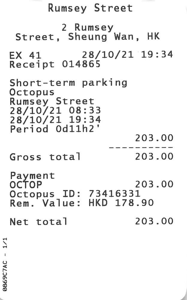

In [3]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [4]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"text_sequence": "Rumsey Street\n2 Rumsey\nStreet, Sheung Wan, HK\nEX 41\t28/10/21 19:34\nReceipt 014865\nShort-term parking\nOctopus\nRumsey Street\n28/10/21 08:33\n28/10/21 19:34\nPeriod Od11h2'\n\t203.00\nGross total\t203.00\nPayment\nOCTOP\t203.00\nOctopus ID: 73416331\nRem. Value: HKD 178.90\nNet total\t203.00\n0869C7AC - 1/1"}}


In [5]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

In [6]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
import numpy as np
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.
    
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).
    
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"", fr""])
                    output += (
                        fr""
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr""
                    )
                return output
        elif type(obj) == list:
            return r"".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [8]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("DataPreprocessing/dataset", max_length=max_length,
                             split="train", task_start_token="", prompt_end_token="",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("DataPreprocessing/dataset", max_length=max_length,
                             split="validation", task_start_token="", prompt_end_token="",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Resolving data files: 100%|██████████| 19/19 [00:00<00:00, 84959.25it/s]
Found cached dataset imagefolder (/home/abdo/.cache/huggingface/datasets/imagefolder/dataset-bedff4d9b9c89aed/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
Resolving data files: 100%|██████████| 19/19 [00:00<00:00, 78514.07it/s]
Found cached dataset imagefolder (/home/abdo/.cache/huggingface/datasets/imagefolder/dataset-bedff4d9b9c89aed/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [9]:
len(added_tokens)

0

In [10]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57525


In [11]:
processor.decode([57520])

'käytetään'

In [12]:
pixel_values, labels, target_sequence = train_dataset[0]

In [13]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [14]:
print(target_sequence)

Rumsey Street
2 Rumsey
Street, Sheung Wan, HK
EX 41	28/10/21 19:34
Receipt 014865
Short-term parking
Octopus
Rumsey Street
28/10/21 08:33
28/10/21 19:34
Period Od11h2'
	203.00
Gross total	203.00
Payment
OCTOP	203.00
Octopus ID: 73416331
Rem. Value: HKD 178.90
Net total	203.00
0869C7AC - 1/1</s>


In [15]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([''])[0]

In [16]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <unk>


In [17]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [18]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [19]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [20]:
config = {"max_epochs":15,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 64,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 6, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [ ]:
from pytorch_lightning.callbacks import Callback, EarlyStopping

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed", # we'll use mixed precision
        num_sanity_val_steps=0,
        callbacks=[early_stop_callback],
)

trainer.fit(model_module)